In [1]:

from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from google import genai
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
import operator

In [2]:

load_dotenv()

True

In [3]:
review="very worst product"

In [4]:
prompt=f"give the sentiment of the sentence only in string 'positive' or 'negative'based on this review: {review}"

In [5]:
client = genai.Client()
response = client.models.generate_content(
model="gemini-2.5-flash",contents=prompt
)
sentiment=response.text

In [6]:
print(sentiment)

negative


In [22]:
print(initial_state[review])

very worst product


In [53]:
class Review(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis:dict
    response:str

In [63]:
def find_sentiment(state: Review) -> dict:
    client = genai.Client()  # Uses API key from .env automatically
    prompt = f"give the sentiment of the sentence only in string 'positive' or 'negative' based on this review: {state['review']}"
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )
    state['sentiment'] = response.text.strip().lower()
    return state

def check_sentiment(state: Review) -> Literal["positive_response", "run_diagnosis"]:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

def positive_response(state: Review) -> dict:
    client = genai.Client()
    prompt = f"""Write a warm thank-you message in response to this review:
\"{state['review']}\"
Also, kindly ask the user to leave feedback on our website."""
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )
    state['response'] = response.text
    return state

def run_diagnosis(state: Review) -> dict:
    client = genai.Client()
    prompt = f"""Diagnose this negative review:
{state['review']}
Return issue_type, tone, and urgency as JSON format."""
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )
    state['diagnosis'] = response.text
    return state

def negative_response(state: Review) -> dict:
    client = genai.Client()
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
The user had the following diagnosis: {diagnosis}.
Write an empathetic, helpful resolution message."""
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )
    state['response'] = response.text
    return state


In [ ]:
initial_state = {
    "review":  "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}

graph = StateGraph(Review)
graph.add_node("find_sentiment", find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()
result = workflow.invoke(initial_state)

print(result.split('\n')[0])  # Print only the first line of the response


{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.', 'sentiment': 'negative', 'diagnosis': '```json\n{\n  "issue_type": "Technical Bug",\n  "tone": "Frustrated",\n  "urgency": "Critical"\n}\n```', 'response': "Subject: Good News: Your Critical Technical Bug Has Been Resolved!\n\nHi [User Name],\n\nI completely understand your frustration and the critical impact this technical bug has had – I'm truly sorry for the trouble and disruption it caused. Thank you for your patience and for bringing this urgent issue to our attention.\n\nI'm happy to let you know that our team has successfully identified and resolved the problem! The fix has now been deployed to our systems.\n\n**What to do next:**\n\n*   Please try [**specific action, e.g., refreshing your browser/application, logging out and back in, re-

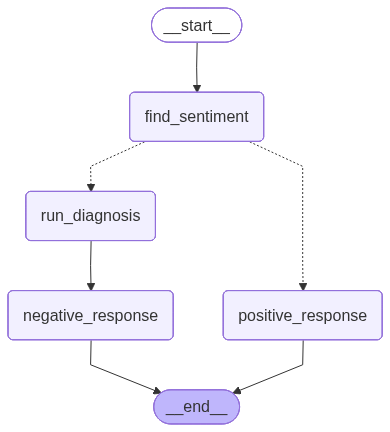

In [72]:
workflow

In [ ]:
print(result)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.', 'sentiment': 'negative', 'diagnosis': '```json\n{\n  "issue_type": "Technical Bug",\n  "tone": "Frustrated",\n  "urgency": "Critical"\n}\n```', 'response': "Subject: Good News: Your Critical Technical Bug Has Been Resolved!\n\nHi [User Name],\n\nI completely understand your frustration and the critical impact this technical bug has had – I'm truly sorry for the trouble and disruption it caused. Thank you for your patience and for bringing this urgent issue to our attention.\n\nI'm happy to let you know that our team has successfully identified and resolved the problem! The fix has now been deployed to our systems.\n\n**What to do next:**\n\n*   Please try [**specific action, e.g., refreshing your browser/application, logging out and back in, re-

In [67]:
for key, value in result.items():
    print(f"{key}: {value}\n")

review: I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.

sentiment: negative

diagnosis: ```json
{
  "issue_type": "Technical Bug",
  "tone": "Frustrated",
  "urgency": "Critical"
}
```

response: Subject: Good News: Your Critical Technical Bug Has Been Resolved!

Hi [User Name],

I completely understand your frustration and the critical impact this technical bug has had – I'm truly sorry for the trouble and disruption it caused. Thank you for your patience and for bringing this urgent issue to our attention.

I'm happy to let you know that our team has successfully identified and resolved the problem! The fix has now been deployed to our systems.

**What to do next:**

*   Please try [**specific action, e.g., refreshing your browser/application, logging out and back in, re-attempting the process that was 

In [71]:
for i in result:
    print(i)

review
sentiment
diagnosis
response
